# MNIST DIGIT DATASET
1. Using Angle encoding
2. Using MPS
3. Using PCA

In [75]:
import time
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from torchsummary import summary


### Data Loading and Data Exploration 

In [2]:
# Modifiying the MNIST DIGIT for Binary Classification: 
# Load the dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Binary classification: Select digits 0 and 1
binary_train_filter = np.where((y_train == 0) | (y_train == 1))
binary_test_filter = np.where((y_test == 0) | (y_test == 1))

x_train, y_train = x_train[binary_train_filter], y_train[binary_train_filter]
x_test, y_test = x_test[binary_test_filter], y_test[binary_test_filter]

# Normalize the images to [0, 1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

# Flatten the images to be vectors of 784 elements
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# Convert labels to float32 for compatibility with PennyLane
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


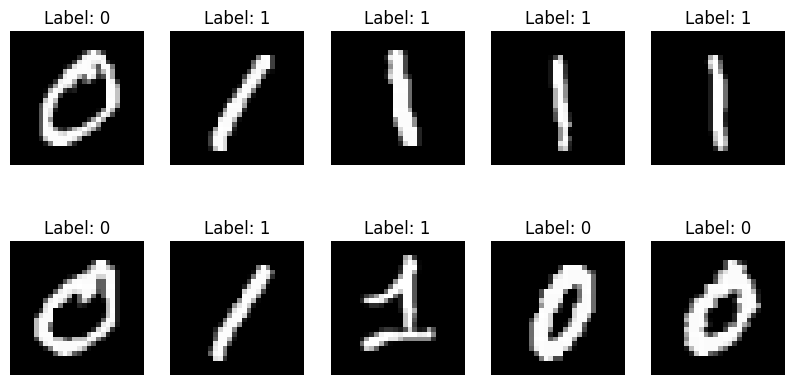

Training images shape: (12665, 784)
Test images shape: (2115, 784)
Shape of an individual training image (before flattening): (28, 28)
Shape of an individual test image (before flattening): (28, 28)


In [8]:
# Visualize some sample images from the training set
def plot_sample_images(images, labels, num_rows=2, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {int(labels[i])}")
        ax.axis('off')
    plt.show()

# Plot 10 sample images
plot_sample_images(x_train, y_train)

# Print the shape of the images array to see the size of the images
print(f"Training images shape: {x_train.shape}")
print(f"Test images shape: {x_test.shape}")

# Print the shape of an individual image before flattening
#print(f"Shape of an individual training image (before flattening): {x_train[0].reshape(28, 28).shape}")
#print(f"Shape of an individual test image (before flattening): {x_test[0].reshape(28, 28).shape}")

### Defining the Quantum Layer and Model 

In [76]:
import torch
from torch import nn
import torch.nn.functional as F
import pennylane as qml

# Define the quantum device
dev = qml.device('default.qubit', wires=4)

# Define a quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(4))
    qml.templates.BasicEntanglerLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(4)]

class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        self.weights = nn.Parameter(torch.randn(3, 4))  # 3 layers, 4 qubits

    def forward(self, x):
        # Applying the quantum node to each item in the batch
        # Use torch.stack to ensure the outputs are correctly shaped as a batch tensor
        q_out = [quantum_circuit(x[i], self.weights) for i in range(x.size(0))]
        return torch.stack([torch.tensor(i, dtype=torch.float32) for i in q_out]).to(x.device)

# Define the hybrid quantum-classical class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        quantum_input = x[:, :4]  # We're encoding the first 4 features
        quantum_output = self.quantum_layer(quantum_input)
        x = torch.cat([x, quantum_output], dim=1)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification

net = Net()
model = Net().to(device)
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 64]           8,256
      QuantumLayer-3                    [-1, 4]               0
            Linear-4                    [-1, 1]              69
Total params: 108,805
Trainable params: 108,805
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


### Training the model 

Starting training...
Epoch 1/10 - Loss: 0.4946043993336986
Epoch 2/10 - Loss: 0.49206367037212007
Epoch 3/10 - Loss: 0.5081407800316811
Epoch 4/10 - Loss: 0.5038370265051572
Epoch 5/10 - Loss: 0.49319035033083924
Epoch 6/10 - Loss: 0.49253727458041124
Epoch 7/10 - Loss: 0.4919591178797712
Epoch 8/10 - Loss: 0.49201955187200297
Epoch 9/10 - Loss: 0.49203634224455767
Epoch 10/10 - Loss: 0.4920111615398918
Training completed in 680.506 seconds.


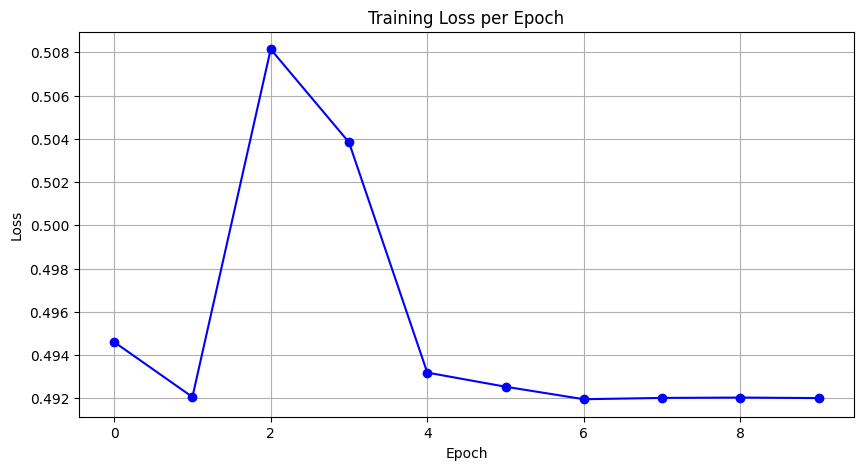

In [26]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import time

# Assuming the necessary imports and data loading from previous steps are already done
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming x_train, y_train, x_test, and y_test are already defined
# Create DataLoader for training and testing
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
trainloader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
testloader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Instantiate the network
net = Net().to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# To keep track of the loss values
losses = []

# Training the network
epochs = 10
print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss/len(trainloader)}")
        losses.append(running_loss / len(trainloader))

end_time = time.time()
print(f"Training completed in {end_time - start_time:.3f} seconds.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()



### Evaluation

Accuracy: 0.9985815602836879
Precision: 0.9973637961335676
Recall: 1.0
F1 Score: 0.9986801583809943


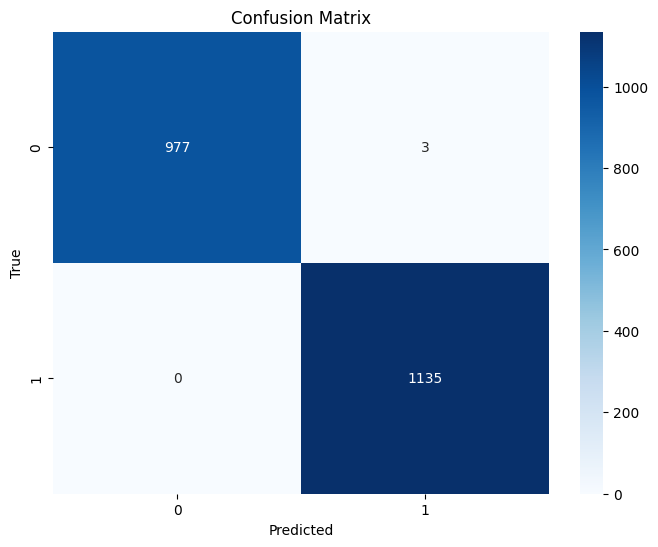

In [27]:


# Evaluation
net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)
        outputs = net(images)
        preds = torch.round(outputs)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## The previous architecture only selected the first 4 features prior the quantum layer. In this part of the code, we Apply PCA to derive more important features: 

Fitting PCA on the Intermediate Output:

We first pass some training data through the Net class (up to the second fully connected layer) and fit PCA on this 64-dimensional output.
Creating the HybridNet Class:

The HybridNet class integrates the PCA transformation into the forward pass before the quantum layer.
Training Loop:

The training loop uses the HybridNet class for training and evaluation.




In [78]:
from sklearn.decomposition import PCA
import torch

# Define the hybrid quantum-classical class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

# Instantiate the network
net = Net().to(device)

# Fit PCA on the output of the second fully connected layer
net.eval()
with torch.no_grad():
    outputs = []
    for images, _ in trainloader:
        images = images.to(device)
        images = images.view(images.shape[0], -1)
        outputs.append(net(images).cpu().numpy())
outputs = np.concatenate(outputs)
pca = PCA(n_components=4)
pca.fit(outputs)

# Define the final hybrid network with PCA transformation
class HybridNet(nn.Module):
    def __init__(self, pca):
        super(HybridNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification
        self.pca = pca

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Apply PCA to get the most important 4 features
        quantum_input = torch.tensor(self.pca.transform(x.detach().cpu().numpy()), dtype=torch.float32).to(x.device)
        quantum_output = self.quantum_layer(quantum_input)
        x = torch.cat([x, quantum_output], dim=1)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification

# Instantiate the final network
hybrid_net = HybridNet(pca).to(device)



summary(hybrid_net, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 64]           8,256
      QuantumLayer-3                    [-1, 4]               0
            Linear-4                    [-1, 1]              69
Total params: 108,805
Trainable params: 108,805
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


#### Now we repeat the training step and evaluation step  

Starting training...
Epoch 1/10 - Loss: 0.4977663422774787
Epoch 2/10 - Loss: 0.49164245036816356
Epoch 3/10 - Loss: 0.49139944870363583
Epoch 4/10 - Loss: 0.49147999249022417
Epoch 5/10 - Loss: 0.4912425123079859
Epoch 6/10 - Loss: 0.49139558072343015
Epoch 7/10 - Loss: 0.4912446361750063
Epoch 8/10 - Loss: 0.4912710778339945
Epoch 9/10 - Loss: 0.4913345722086502
Epoch 10/10 - Loss: 0.49141724084061805
Training completed in 664.457 seconds.


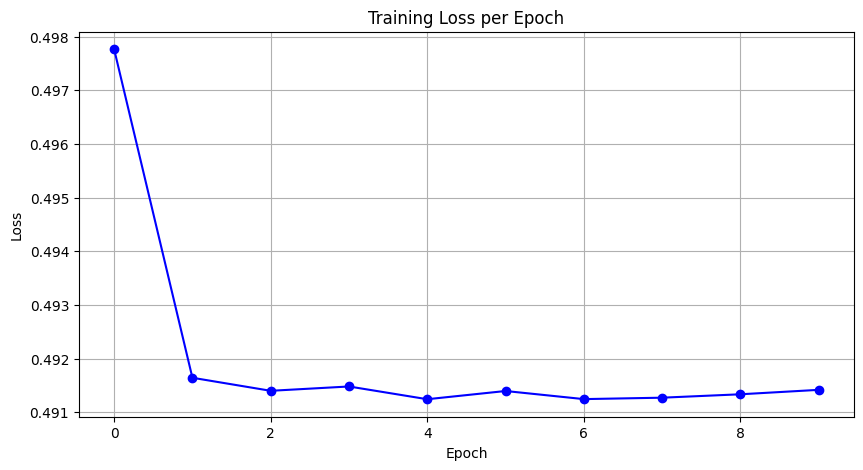

Accuracy: 0.9995271867612293
Precision: 1.0
Recall: 0.9991189427312775
F1 Score: 0.999559277214632


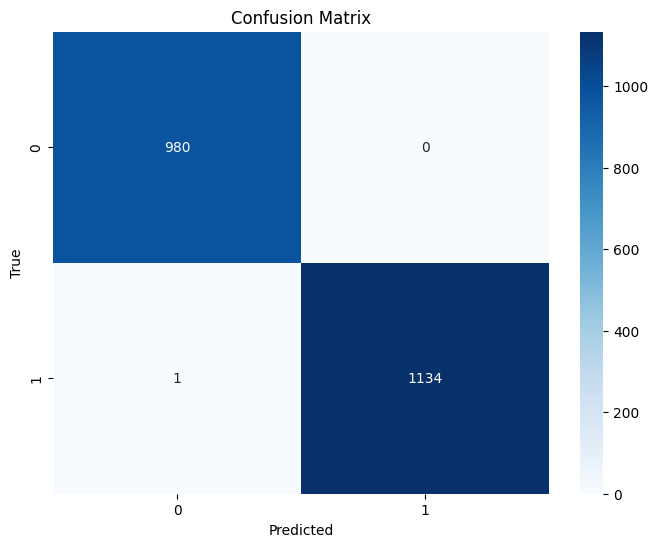

In [34]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(hybrid_net.parameters(), lr=0.001)

# To keep track of the loss values
losses = []

# Training the network
epochs = 10
print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = hybrid_net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss/len(trainloader)}")
        losses.append(running_loss / len(trainloader))

end_time = time.time()
print(f"Training completed in {end_time - start_time:.3f} seconds.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation
hybrid_net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)
        outputs = hybrid_net(images)
        preds = torch.round(outputs)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# MPS feature Extractor

I will attempt to create a a feature extractor for a variational quantum circuit (VQC) based on tensor networks, specifically using the matrix product state (MPS) with low bond dimensions, as described in the paper by Chen et al in '"An end-to-end trainable hybrid classical-quantum classifier".
I will Integrate a Matrix Product State (MPS) feature extractor with a hybrid quantum-classical neural network I'll handle the MPS feature extraction using classical tensor network techniques and then pass these features to a quantum circuit

The Matrix Product State (MPS) layer is a type of tensor network that can be used for efficient representation and computation of high-dimensional data. MPS has its roots in quantum physics but has found applications in machine learning due to its ability to capture complex correlations in data with fewer parameters than traditional methods.

How the MPS Layer Works
Representation:

MPS represents a high-dimensional tensor (such as an image) as a sequence of lower-dimensional tensors connected in a chain-like structure. This factorization reduces the number of parameters needed to describe the system.
Efficiency:

By breaking down the high-dimensional tensor into a series of smaller tensors, MPS can efficiently handle large-scale data while capturing the important correlations within the data.
Training:

During training, the parameters of the MPS (the smaller tensors) are optimized to minimize the loss function. This process allows the MPS to learn the underlying structure and features of the input data.
Benefits of Using an MPS Layer
Parameter Efficiency:

MPS can represent complex functions with fewer parameters compared to fully connected layers. This efficiency can be particularly beneficial when dealing with high-dimensional data.
Capturing Long-Range Correlations:

MPS is capable of capturing long-range correlations in data, which can be advantageous for tasks where such correlations are important.
Scalability:

Due to its factorized representation, MPS can scale to larger input sizes without a corresponding exponential increase in the number of parameters.
Theoretical Insights:

MPS provides a theoretical framework for understanding the expressiveness and capabilities of neural networks from a tensor network perspective.

In [62]:
#Defining the MPS lAYER
import tensorly as tl
from tensorly.decomposition import matrix_product_state
from tensorly.tenalg import multi_mode_dot

# Define the quantum device
dev = qml.device('default.qubit', wires=4)


class MPSLayer(nn.Module):
    def __init__(self, num_pixels, bond_dim, output_dim):
        super(MPSLayer, self).__init__()
        self.num_pixels = num_pixels
        self.bond_dim = bond_dim
        self.output_dim = output_dim
        
        # Randomly initialize the MPS tensors
        self.tensors = nn.ParameterList([
            nn.Parameter(torch.randn(bond_dim, bond_dim)) for _ in range(num_pixels)
        ])

    def forward(self, x):
        # Flatten and normalize the image
        x = x.view(-1, self.num_pixels) / 255.0
        
        # Initialize the state of the system
        state = torch.eye(self.bond_dim)[None, :, :].repeat(x.shape[0], 1, 1)
        
        # Contract the input with the MPS tensors
        for i in range(self.num_pixels):
            # Expand the current pixel to the bond dimension
            pixel = x[:, i].unsqueeze(1).unsqueeze(2)
            tensor = self.tensors[i].unsqueeze(0)
            state = state @ (tensor * pixel)

        # Sum over the second dimension to get the final state
        state = state.sum(dim=2)

        # Ensure output dimensionality matches the desired output_dim
        if self.bond_dim > self.output_dim:
            return state[:, :self.output_dim]
        elif self.bond_dim < self.output_dim:
            # Pad the output if bond dimension is less than required output_dim
            padding = torch.zeros((state.size(0), self.output_dim - self.bond_dim), device=state.device)
            return torch.cat([state, padding], dim=1)
        return state



In [63]:
# Define the quantum device
dev = qml.device('default.qubit', wires=4)

# Define a quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(4))
    qml.templates.BasicEntanglerLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(4)]

class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        self.weights = nn.Parameter(torch.randn(3, 4))  # 3 layers, 4 qubits

    def forward(self, x):
        q_out = [quantum_circuit(x[i], self.weights) for i in range(x.size(0))]
        return torch.stack([torch.tensor(i, dtype=torch.float32) for i in q_out]).to(x.device)

# Define the hybrid network with the MPS and quantum layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.mps_layer = MPSLayer(num_pixels=28*28, bond_dim=10, output_dim=64)  # Adjust bond_dim and output_dim as needed
        self.fc1 = nn.Linear(64, 64)  # Ensure input dim matches output_dim of MPS layer
        self.dropout1 = nn.Dropout(0.5)
        self.quantum_layer = QuantumLayer()
        self.fc2 = nn.Linear(64 + 4, 1)  # Adjust for the output from the quantum layer
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.mps_layer(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        # Take the first 4 features
        quantum_input = x[:, :4]
        quantum_output = self.quantum_layer(quantum_input)
        x = torch.cat([x, quantum_output], dim=1)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification


Starting training...
Epoch 1/10 - Loss: 0.7082300399891054
Epoch 2/10 - Loss: 0.7078831287646534
Epoch 3/10 - Loss: 0.707880913007139
Epoch 4/10 - Loss: 0.7079145324350608
Epoch 5/10 - Loss: 0.7079027463691403
Epoch 6/10 - Loss: 0.7078696022732089
Epoch 7/10 - Loss: 0.7078804789167462
Epoch 8/10 - Loss: 0.707891690008568
Epoch 9/10 - Loss: 0.7078480029648001
Epoch 10/10 - Loss: 0.7079579334969472
Training completed in 1381.364 seconds.


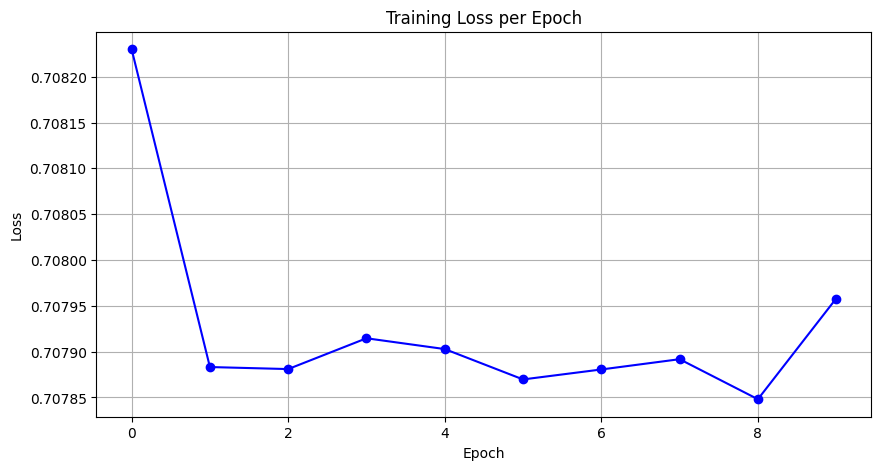

In [66]:
# Initialize and train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Use a smaller learning rate

# Training loop
epochs = 10  # Increase the number of epochs
losses = []

print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #images, labels = images.to(device), labels.to(device).unsqueeze(1).float()
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1).squeeze(2)

        
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss/len(trainloader)}")
    losses.append(running_loss / len(trainloader))

end_time = time.time()
print(f"Training completed in {end_time - start_time:.3f} seconds.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Accuracy: 0.5366430260047281
Precision: 0.5366430260047281
Recall: 1.0
F1 Score: 0.6984615384615385


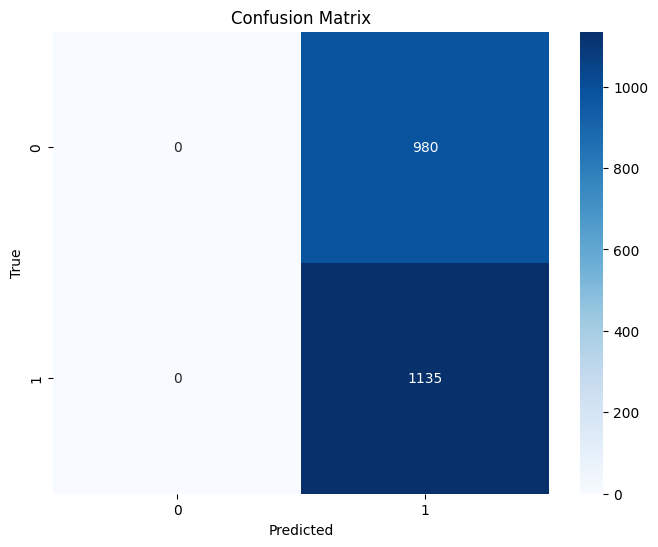

In [73]:
#EVALUATE


# Evaluation
net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1).squeeze(2)
        outputs = net(images)
        preds = torch.round(torch.sigmoid(outputs))
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=1)
recall = recall_score(all_labels, all_preds, zero_division=1)
f1 = f1_score(all_labels, all_preds, zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()





